### FLiBe Simple

In [3]:
import openmc
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.ticker import MultipleLocator, ScalarFormatter

In [4]:
# Helper functions
def logspace_per_decade(start, stop, pts_per_decade):
    """
    Returns values from 'start' to 'stop' so that each factor-of-10
    interval contains 'pts_per_decade' points (including its first endpoint).
    Might be a little off if 'stop' isn't precisely at a decade, ex. 20e6 eV

    example: 10 points per decade from 1e-5 → 2e7
    grid = logspace_per_decade(1e-5, 20e6, pts_per_decade=10)
    for i in grid:
        print(np.log10(i))
    # print(np.log10(i) for i in grid)
    """
    log_start = np.log10(start)
    log_stop  = np.log10(stop)
    total_decades = log_stop - log_start
    # how many intervals of size 1 decade we need, as a float
    total_steps = total_decades * pts_per_decade
    # +1 so that we include the very last point at `stop`
    npts = int(np.ceil(total_steps)) + 1
    return np.logspace(log_start, log_stop, num=npts)


def log_midpoints(points):
    """
    Compute logarithmic midpoints between adjacent points in a list.
    The logarithmic midpoint m between two positive values a and b is
    defined as the geometric mean: m = sqrt(a * b).

    Args:
        points: List of floats (must be positive).

    Returns:
        List of floats of length len(points) - 1, where each entry
        is the logarithmic midpoint between points[i] and points[i+1].
    """
    if any(p <= 0 for p in points):
        raise ValueError("All points must be positive to compute log midpoints.")
    return [float(np.sqrt(points[i] * points[i + 1])) for i in range(len(points) - 1)]

"""
Font settings for matplotlib
"""
font_path = './helper/arial.ttf'  # Your font path goes here
fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)

plt.rcParams['font.family'] = prop.get_name()



# Testing
print(log_midpoints([1e-3, 1e-2, 1e-1, 1e0]))

[0.0031622776601683794, 0.03162277660168379, 0.31622776601683794]


Neutronics codes like MCNP and OpenMC define some model on an input deck or file. This input has three main components: Materials, Geometry, and Problem Settings. 
### Materials
We define the composition . Each `Material` class is given some density, temperature, and isotopic composition. Materials can be (homogeneously) mixed to create a new material. The materials we actually use in the problem are then collected into the `Materials` class and exported as an `.xml` file.

In [48]:
# User specifications
DENSITY_FLIBE = 1.8 # usu 1.8-2.0 g/cc
ENRICH_LI = 20
MOL_LIF, MOL_BEF2 = 0.66, 0.34
TEMP = 900 # K

mu_val, mf_val = 0, 0
M_U, M_FLIBE = [], []
MR_U, MR_FLIBE = [], []
M_U_val = [0, 0.1, 1, 2.5, 5, 10, 20 ,30 ,40, 50]

VOL = 342 * 100e3 # cm3

for mass in M_U_val:
    mu_val, mf_val = 0.0181*mass/50, 1 # in Ball et al. --EZ
    M_U.append(mu_val)
    M_FLIBE.append(mf_val)
    MR_U.append(mu_val / (mu_val + mf_val))
    MR_FLIBE.append(mf_val / (mu_val + mf_val)) # mol ratios
print('mol ratio uranium', MR_U)
print('mol ratio flibe', MR_FLIBE)
""" 
MATERIALS
  OpenMC automatically normalizes the fraction of each element in material (like MCNP)
  but the fractions in 'mix_materials' MUST add up to 1
"""
flibe = openmc.Material(name="FLiBe", temperature=TEMP)
flibe.set_density('g/cm3', DENSITY_FLIBE) 
flibe.add_element('Li',MOL_LIF,'ao',ENRICH_LI,'Li6','wo')
flibe.add_element('Be',MOL_BEF2,'ao')
flibe.add_element('F',(MOL_LIF+2*MOL_BEF2),'ao')

uranium = openmc.Material(name="U",temperature=TEMP)
uranium.add_element('U',100,'ao',0.7204)
# uranium.add_nuclide('U238',100) --ezoccoli
mix = []
ind = []
for i,val in enumerate(M_U_val):
    ind.append(i)
    mix0 = openmc.Material.mix_materials([flibe, uranium], [MR_FLIBE[i], MR_U[i]], 'ao') # 
    mix0.temperature = 900
    mix.append(mix0)
    print(mix[i].get_nuclide_atom_densities()) # Returns one or all elements in the material and their atomic densities in units of atom/b-cm
# print(f"ppark checksum for FLiBe 1.8 g/cc, 0.64 mol LiF, 0.33 mol BeF2:")
# print(f"  'Li6': 0.00489411249582549, 'Li7': 0.016783401745946593, 'Be9': 0.011167204306367438, 'F19': 0.04401192285450695")

materials = openmc.Materials(mix)
materials.cross_sections = '/opt/openmc_data/endfb-viii.0-hdf5/cross_sections.xml' # use this on zotac --ppark
# materials.cross_sections = '/mnt/c/openmc/data/endfb-viii.0-hdf5/cross_sections.xml' # use this on zotac --ppark
# os.makedirs("./xml/", exist_ok=True) 
# materials.export_to_xml("./xml/materials.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

mol ratio uranium [0.0, 3.619868960743621e-05, 0.00036186900342076174, 0.0009041817155474297, 0.0018067298190275602, 0.0036069428668221047, 0.007187959175568883, 0.010743327463743743, 0.014273322293194543, 0.017778214320793635]
mol ratio flibe [1.0, 0.9999638013103925, 0.9996381309965793, 0.9990958182844526, 0.9981932701809724, 0.9963930571331779, 0.9928120408244312, 0.9892566725362562, 0.9857266777068054, 0.9822217856792064]
{'Li6': 0.004894023506591363, 'Li7': 0.01678343124082244, 'Be9': 0.011167173657758628, 'F19': 0.044011802062931066, 'U234': 0.0, 'U235': 0.0, 'U238': 0.0, 'U236': 0.0}
{'Li6': 0.004894023370429711, 'Li7': 0.016783430773873363, 'Be9': 0.01116717334706522, 'F19': 0.04401180083843352, 'U234': 1.81421864719168e-10, 'U235': 2.0297494673646208e-08, 'U238': 2.7616308167256433e-06, 'U236': 9.297227481680796e-11}
{'Li6': 0.004894022144975163, 'Li7': 0.016783426571332836, 'Be9': 0.011167170550825332, 'F19': 0.04401178981795866, 'U234': 1.8142181929146314e-09, 'U235': 2.0297

#### Geometry
For our simple case suppose we make a 1 m$^3$ cube with reflective surfaces of homogeneous FLiBe. We define a cubical cell defined by 6 planes, and place this cell in the "universe." (Alex actually suggested switching from 1 cm side to 1 m side because if the geometry is too small we'll spend too much computational time calculating neutron reflections.) Then, like the materials, we export these definitions to `geometry.xml`.

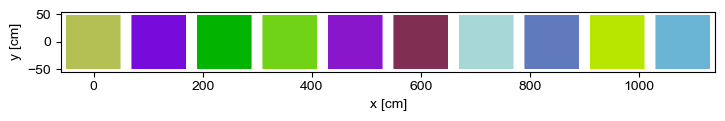

In [49]:
""" GEOMETRY
"""
cells = []
spacing = 120  # enough space between cells to avoid overlap
half_box = 50  # match your ±50 bounds

for i, material in enumerate(mix):
    x_offset = i * spacing
    x_min = openmc.XPlane(x0=-half_box + x_offset, boundary_type='reflective')
    x_max = openmc.XPlane(x0=half_box + x_offset, boundary_type='reflective')
    ymin = openmc.YPlane(-50, boundary_type='reflective')
    ymax = openmc.YPlane( 50, boundary_type='reflective')
    zmin = openmc.ZPlane(-50, boundary_type='reflective')
    zmax = openmc.ZPlane( 50, boundary_type='reflective')
    region = +x_min & -x_max & +ymin & -ymax & +zmin & -zmax
    cell = openmc.Cell(fill=material, region=region)
    cell.name = f"mix-{i+1}"
    cells.append(cell)

# Create root universe with all material cells
root_univ = openmc.Universe(cells=cells)

# Visualization and geometry definition
root_univ.plot(width=(spacing * len(mix), 110), origin=(spacing * (len(mix) - 1) / 2, 0.0, 0.0))
geometry = openmc.Geometry(root_univ)

# geometry.export_to_xml("./xml/geometry.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

#### Settings
Here we define the other settings for our problem. 

In [50]:
""" 
SETTINGS
"""
settings = openmc.Settings()

""" Tallies
"""
E_bin_edges = logspace_per_decade(1e-5, 20e6, 100)
energy_filter = openmc.EnergyFilter(E_bin_edges)
tallies = openmc.Tallies() #initialize
cell_filter_map = {}
for i, cell in enumerate(cells):  #filter for each cell of mass composition
    cell_filter = openmc.CellFilter(cell)
    cell_filter_map[cell.id] = cell.name 
    filters = [energy_filter, cell_filter]
# helper function 'logspace_per_decade' from above
# energy_filter = openmc.EnergyFilter.from_group_structure('CCFE-709')
#   These have extra bins in key energy ranges. A full list of energy structures is available here: --ppark 2025-06-27
#   https://github.com/openmc-dev/openmc/blob/6254be37582e09acff038f5656332b89e53e4eae/openmc/mgxs/__init__.py#L50-L420

    # Flux tally
    flux_tally = openmc.Tally(name=f'flux tally - {cell.name}')
    flux_tally.scores = ['flux'] # specific names required
    # flux_tally.nuclides = ['U238', 'U235']
    flux_tally.filters = filters

    # (Uranium) Tally
    U_tally = openmc.Tally(name=f'U tally - {cell.name}')
    U_tally.scores = ['(n,gamma)','fission', 'elastic'] # specific names required
    U_tally.nuclides = ['U238', 'U235']
    U_tally.filters = filters

    # (Li) Tally
    Li_tally = openmc.Tally(name=f'Li tally - {cell.name}')
    Li_tally.scores = ['(n,gamma)','(n,t)', 'elastic'] # specific names required
    Li_tally.nuclides = ['Li6', 'Li7']
    Li_tally.filters = filters

    # (F) Tally
    F_tally = openmc.Tally(name=f'F tally - {cell.name}')
    F_tally.scores = ['(n,gamma)', 'elastic'] # specific names required
    F_tally.nuclides = ['F19']
    F_tally.filters = filters

    # (Be) Tally
    Be_tally = openmc.Tally(name=f'Be tally - {cell.name}')
    Be_tally.scores = ['(n,gamma)','(n,2n)', 'elastic'] # specific names required
    Be_tally.nuclides = ['Be9']
    Be_tally.filters = filters
    tallies.extend([flux_tally, U_tally, Li_tally, F_tally, Be_tally])


    # tallies.export_to_xml("./xml/tallies.xml") --don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

""" 
Source
  Isotropic 14.07 MeV point source at center of each cube
"""
points = [(0,0,0),(120,0,0),(240,0,0),(360,0,0),(480,0,0),(600,0,0),(720,0,0),(840,0,0),(960,0,0),(1080,0,0)]
source = []
for p in points:
    src = openmc.IndependentSource()
    src.space  = openmc.stats.Point(p)
    src.angle  = openmc.stats.Isotropic()
    src.energy = openmc.stats.Discrete([14.07e6], [1.0])
    source.append(src)

settings.source = source

"""
Run type
"""
settings.run_mode = 'fixed source'
settings.particles = int(1e5)
settings.generations_per_batch = 20
settings.batches = 100
settings.inactive = 10

# settings.export_to_xml("./xml/settings.xml") # don't need bc 'model.export_to_model_xml' below --ppark 2025-06-28

Patrick: I changed `model.export_to_xml()` to `model.export_to_model_xml` so that only 1 xml is printed with all of the information, instead of 3 separate xml files.

In [51]:
model = openmc.model.Model(geometry, materials, settings, tallies)
model.export_to_model_xml("./model/") 

In [52]:
print("=== MATERIALS IN MODEL ===")
for material in model.materials:
    print(f"Material ID: {material.id}, Name: {material.name}, Density: {material.density} g/cm³")
    for nuclide, amount in material.get_nuclide_atom_densities().items():
        print(f"  {nuclide}: {amount} [atoms/b-cm]")
        
        
print("\n=== SETTINGS IN MODEL ===")
print(f"Run Mode: {model.settings.run_mode}")
print(f"Particles: {model.settings.particles}")
print(f"Batches: {model.settings.batches}")
print(f"Source: {model.settings.source}")

print(model.settings)

print("\n=== TALLIES IN MODEL ===")
for tally in model.tallies:
    print(f"Tally Name: {tally.name}")
    print(f"  Scores: {tally.scores}")
    print(f"  Nuclides: {tally.nuclides if hasattr(tally, 'nuclides') else 'All'}")
    for f in tally.filters:
        print(f"  Filter Type: {type(f).__name__}, Bins: {getattr(f, 'bins', 'N/A')}")

=== MATERIALS IN MODEL ===
Material ID: 26, Name: FLiBe(1.0)-U(0.0), Density: 1.7999999999999994 g/cm³
  Li6: 0.004894023506591363 [atoms/b-cm]
  Li7: 0.01678343124082244 [atoms/b-cm]
  Be9: 0.011167173657758628 [atoms/b-cm]
  F19: 0.044011802062931066 [atoms/b-cm]
  U234: 0.0 [atoms/b-cm]
  U235: 0.0 [atoms/b-cm]
  U238: 0.0 [atoms/b-cm]
  U236: 0.0 [atoms/b-cm]
Material ID: 27, Name: FLiBe(0.9999638013103925)-U(3.619868960743621e-05), Density: 1.8010996312865934 g/cm³
  Li6: 0.004894023370429711 [atoms/b-cm]
  Li7: 0.016783430773873363 [atoms/b-cm]
  Be9: 0.01116717334706522 [atoms/b-cm]
  F19: 0.04401180083843352 [atoms/b-cm]
  U234: 1.81421864719168e-10 [atoms/b-cm]
  U235: 2.0297494673646208e-08 [atoms/b-cm]
  U238: 2.7616308167256433e-06 [atoms/b-cm]
  U236: 9.297227481680796e-11 [atoms/b-cm]
Material ID: 28, Name: FLiBe(0.9996381309965793)-U(0.00036186900342076174), Density: 1.8109963101124806 g/cm³
  Li6: 0.004894022144975163 [atoms/b-cm]
  Li7: 0.016783426571332836 [atoms/b-cm

Run OpenMC

In [53]:
results_NSlow = model.run(cwd="./model/") # cwd="./xml")

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

In [46]:
# open the results file

tally_data = {}


with openmc.StatePoint(results_NSlow) as sp:
    for cell in cells:                                            
        cell_name = cell.name
        if cell_name not in tally_data:
            tally_data[cell_name] = {}

        tally_names = ['flux tally', 'U tally', 'Li tally', 'F tally', 'Be tally']
        for name in tally_names:
            full_name = f'{name} - {cell_name}'
            tally = sp.get_tally(name=full_name)
            tally_data[cell_name][name] = tally

cell_summary = {}
bin_summary = {}

for cell_name, tallies in tally_data.items():
    flux_tally = tallies['flux tally']
    U_tally = tallies['U tally']
    Li_tally = tallies['Li tally']

    # Extract binned tallies
    flux = flux_tally.get_values(scores=['flux']).sum()
    U235 = U_tally.get_values(scores=['fission'], nuclides=['U235']).sum()
    U238 = U_tally.get_values(scores=['fission'], nuclides=['U238']).sum()
    U238_ng = U_tally.get_values(scores=['(n,gamma)'], nuclides=['U238']).sum()
    Li6 = Li_tally.get_values(scores=['(n,t)'], nuclides=['Li6']).sum()
    
    flux_binned = flux_tally.get_values(scores=['flux']).flatten()
    U235_fission_binned = U_tally.get_values(scores=['fission'],nuclides=['U235']).flatten()
    U238_fission_binned = U_tally.get_values(scores=['fission'],nuclides=['U238']).flatten()
    U238_gamma_binned   = U_tally.get_values(scores=['(n,gamma)'],nuclides=['U238']).flatten()
    Li6_tritium_binned  = Li_tally.get_values(scores=['(n,t)'],nuclides=['Li6']).flatten()

    cell_summary[cell_name] = {
        'Total_flux': flux,
        'U235_fission': U235,
        'U238_fission': U238,
        'U238_gamma': U238_ng,
        'Li6_tritium': Li6,
        }
    bin_summary[cell_name] = {
        'flux_binned': flux_binned,
        'U235_fission_binned': U235_fission_binned,
        'U238_fission_binned': U238_fission_binned,
        'U238_gamma_binned': U238_gamma_binned,
        'Li6_tritium_binned': Li6_tritium_binned
        }

E_bin_centers = E_bin_edges[:-1]
print(f"for 20 tons total_flux   {cell_summary['mix-7']['Total_flux']} \n" \
      f"            U235_fission {cell_summary['mix-7']['U235_fission']} \n" \
      f"            U238_fission {cell_summary['mix-7']['U238_fission']} \n" \
      f"            U238_gamma   {cell_summary['mix-7']['U238_gamma']}   \n" \
      f"            Li6_tritium  {cell_summary['mix-7']['Li6_tritium']}  ")
                                              


for 20 tons total_flux   176.26984517301986 
            U235_fission 0.0020530067849281863 
            U238_fission 0.020715843816202208 
            U238_gamma   0.05069573271252762   
            Li6_tritium  1.1043197896717807  


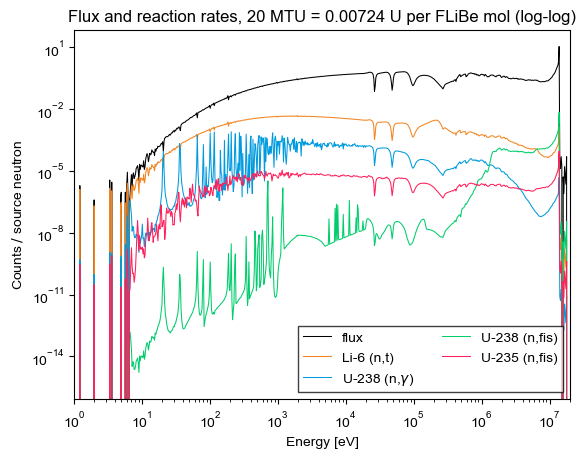

In [47]:
plt.figure()
plt.plot(E_bin_centers, bin_summary['mix-7']['flux_binned'],         linewidth=0.75, color='#000000', label=r'flux')
plt.plot(E_bin_centers, bin_summary['mix-7']['Li6_tritium_binned'],  linewidth=0.75, color='#f28522', label=r'Li-6 (n,t)')
plt.plot(E_bin_centers, bin_summary['mix-7']['U238_gamma_binned'],   linewidth=0.75, color='#009ade', label=r'U-238 (n,$\gamma$)')
plt.plot(E_bin_centers, bin_summary['mix-7']['U238_fission_binned'], linewidth=0.75, color='#00cd6c', label=r'U-238 (n,fis)')
plt.plot(E_bin_centers, bin_summary['mix-7']['U235_fission_binned'], linewidth=0.75, color='#ff1f5b', label=r'U-235 (n,fis)')

plt.xscale('log')
plt.yscale('log')
plt.xlim(1e0,2e7)
plt.xlabel('Energy [eV]')
plt.ylabel('Counts $/$ source neutron')
plt.title('Flux and reaction rates, 20 MTU = 0.00724 U per FLiBe mol (log-log)')
leg = plt.legend(loc='lower right', ncols=2, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
leg.get_frame().set_linewidth(1)

os.makedirs('./figures/', exist_ok=True)
plt.savefig('./figures/fig_20mtu_tallies_log-log.pdf', bbox_inches='tight', format='pdf')
plt.savefig('./figures/fig_20mtu_tallies_log-log.png', bbox_inches='tight', format='png')

plt.show()

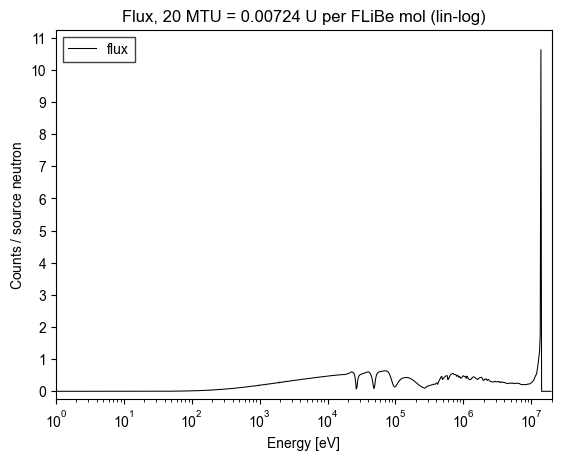

In [212]:
plt.figure()
plt.plot(E_bin_centers, bin_summary['mix-7']['flux_binned'], linewidth=0.75, color='#000000', label=r'flux')

plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e7)
plt.ylim(-0.25,11.25)

plt.gca().yaxis.set_major_locator(MultipleLocator(1)) # force y ticks at every integer

plt.xlabel('Energy [eV]')
plt.ylabel('Counts $/$ source neutron')
plt.title('Flux, 20 MTU = 0.00724 U per FLiBe mol (lin-log)')
leg = plt.legend(loc='upper left', ncols=2, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
leg.get_frame().set_linewidth(1)

os.makedirs('./figures/', exist_ok=True)
plt.savefig('./figures/fig_20mtu_flux_lin-log.pdf', bbox_inches='tight', format='pdf')
plt.savefig('./figures/fig_20mtu_flux_lin-log.png', bbox_inches='tight', format='png')
plt.show()

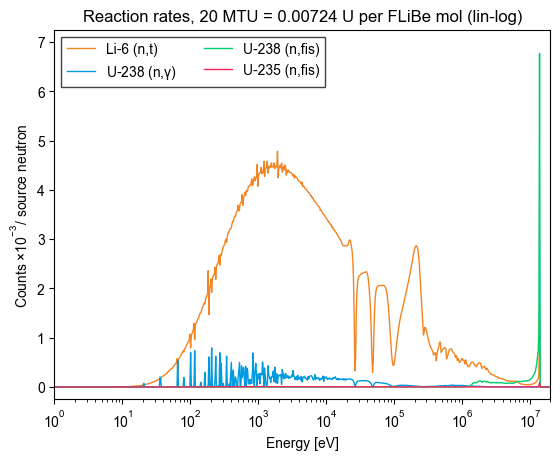

In [213]:
plt.figure()

# plt.plot(E_bin_centers, flux_binned,         linewidth=1, color='#000000', label=r'flux')
plt.plot(E_bin_centers, bin_summary['mix-7']['Li6_tritium_binned']*1e3,  linewidth=1, color='#f28522', label=r'Li-6 (n,t)')
plt.plot(E_bin_centers, bin_summary['mix-7']['U238_gamma_binned*1e3,   linewidth=1, color='#009ade', label=r'U-238 (n,$\gamma$)')
plt.plot(E_bin_centers, U238_fission_binned*1e3, linewidth=1, color='#00cd6c', label=r'U-238 (n,fis)')
plt.plot(E_bin_centers, U235_fission_binned*1e3, linewidth=1, color='#ff1f5b', label=r'U-235 (n,fis)')

plt.xscale('log')
plt.yscale('linear')
plt.xlim(1e0,2e7)
plt.ylim(-0.25,7.25)
# force scientific notation on y-axis
# plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
# plt.gca().ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.xlabel('Energy [eV]')
plt.ylabel(r'Counts $\times 10^{-3}/$ source neutron')
plt.title('Reaction rates, 20 MTU = 0.00724 U per FLiBe mol (lin-log)')

leg = plt.legend(loc='upper left', ncols=2, frameon=True, fancybox=False, edgecolor='black', framealpha=.75,) # fontsize='small', ncols=1, 
leg.get_frame().set_linewidth(1)
# plt.tight_layout()
os.makedirs('./figures/', exist_ok=True)
plt.savefig('./figures/fig_20mtu_tallies_lin-log.pdf', bbox_inches='tight', format='pdf')
plt.savefig('./figures/fig_20mtu_tallies_lin-log.png', bbox_inches='tight', format='png')
plt.show()